In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import h5py
import gzip
import json
import os
import tqdm

import warnings
warnings.filterwarnings('ignore')

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info("Test")

INFO:root:Test


# Define Dataset

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader


class HDF5Dataset(Dataset):
    def __init__(self, name, first_n=10):
        """
        :name: test/train
        :first_n: (temporary) first_n places of origin
        """
        super(HDF5Dataset, self).__init__()
        self.first_n = first_n
        self.hf = h5py.File("data/EpiGCN/train_test.hdf5", "r")
        self.data = self.hf.get("x_train") if name == "train" else self.hf.get("x_test")
        self.target = (
            self.hf.get("y_train") if name == "train" else self.hf.get("y_test")
        )

    def __getitem__(self, index):
        return (
            torch.from_numpy(self.data[index, :self.first_n, :, :, [1, 2]].astype("float")).float(),
            torch.from_numpy(
                self.target[index, :self.first_n, :, :, [1, 2]].astype("float")
            ).float(),
        )

    def __len__(self):
        return self.data.shape[0]

    def __del__(self):
        self.hf.close()

# Define Dataloader

In [3]:
params = {"batch_size": 24, "shuffle": True}
first_n = 100

train_dataset = HDF5Dataset("train", first_n=first_n)
train_dataloader = DataLoader(train_dataset, **params)

test_dataset = HDF5Dataset("test", first_n=first_n)
test_dataloader = DataLoader(test_dataset, **params)

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


# Define the Model!

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class BaselineLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BaselineLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size, batch_first=True
        )
        self.linear = nn.Linear(hidden_size, input_size)

    def forward(self, lstm_input):
        """
        :lstm_input: (b, first_n, 232, 10, 2)
        """
        b, first_n, n_countries, seq_len, sym = lstm_input.size()
        lstm_input = lstm_input.permute(0, 3, 1, 2, 4)
        _, (hn, __) = self.lstm(lstm_input.contiguous().view(b, seq_len, -1))
        return self.linear(hn).view(b, first_n, n_countries, 1, sym)

# Ignite!

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss
from ignite.contrib.handlers.tensorboard_logger import *

model = BaselineLSTM(input_size=232 * first_n * 2, hidden_size=1024)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

mse = torch.nn.MSELoss()
mae = torch.nn.L1Loss()

tb_logger = TensorboardLogger(log_dir="experiments/tb_logs/runs/lr_scheduler")

trainer = create_supervised_trainer(model, optimizer, mae, device=device)

metrics = {"mae": Loss(mae), "mse": Loss(mse)}

train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
validation_evaluator = create_supervised_evaluator(
    model, metrics=metrics, device=device
)

tb_logger.attach(
    trainer,
    log_handler=OutputHandler(
        tag="training", output_transform=lambda loss: {"loss": loss}
    ),
    event_name=Events.ITERATION_COMPLETED,
)

tb_logger.attach(
    train_evaluator,
    log_handler=OutputHandler(
        tag="training",
        metric_names=["mae", "mse"],
        global_step_transform=global_step_from_engine(trainer),
    ),
    event_name=Events.EPOCH_COMPLETED,
)

tb_logger.attach(
    validation_evaluator,
    log_handler=OutputHandler(
        tag="validation",
        metric_names=["mae", "mse"],
        global_step_transform=global_step_from_engine(trainer),
    ),
    event_name=Events.EPOCH_COMPLETED,
)

# Attach the logger to the trainer to log optimizer's parameters, e.g. learning rate at each iteration
tb_logger.attach(
    trainer,
    log_handler=OptimizerParamsHandler(optimizer),
    event_name=Events.ITERATION_STARTED,
)

# Attach the logger to the trainer to log model's weights norm after each iteration
tb_logger.attach(
    trainer,
    log_handler=WeightsScalarHandler(model),
    event_name=Events.ITERATION_COMPLETED,
)

# Attach the logger to the trainer to log model's weights as a histogram after each epoch
tb_logger.attach(
    trainer, log_handler=WeightsHistHandler(model), event_name=Events.EPOCH_COMPLETED
)

# Attach the logger to the trainer to log model's gradients norm after each iteration
tb_logger.attach(
    trainer,
    log_handler=GradsScalarHandler(model),
    event_name=Events.ITERATION_COMPLETED,
)

# Attach the logger to the trainer to log model's gradients as a histogram after each epoch
tb_logger.attach(
    trainer, log_handler=GradsHistHandler(model), event_name=Events.EPOCH_COMPLETED
)


@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(trainer):
    logger.info(
        "Epoch[{}] Loss: {:.7f}".format(trainer.state.epoch, trainer.state.output)
    )


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_dataloader)
    metrics = train_evaluator.state.metrics
    logger.info(
        "Training Results - Epoch: {} MSE: {:.7f} MAE: {:.7f}".format(
            trainer.state.epoch, metrics["mse"], metrics["mae"]
        )
    )


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    validation_evaluator.run(test_dataloader)
    metrics = validation_evaluator.state.metrics
    logger.info(
        "Validation Results - Epoch: {} MSE: {:.7f} MAE: {:.7f}".format(
            trainer.state.epoch, metrics["mse"], metrics["mae"]
        )
    )
    lr_scheduler.step(metrics["mae"])


trainer.run(train_dataloader, max_epochs=100)
# We need to close the logger with we are done
tb_logger.close()

# Visualize results

In [19]:
model.load_state_dict(torch.load('models/model_1.torch'))
model = model.to(device)

## Load Pickled Scaler

In [17]:
import joblib
scaler = joblib.load('data/EpiGCN/standard_scaler.pkl')

In [56]:
def get_scaled_output(y):
    y = y.view(-1, 2).numpy()
    mean = scaler.mean_[[1, 2]]
    scale = scaler.scale_[[1, 2]]
    return (scale * y + mean).reshape(-1, first_n, 232, 1, 2)

In [59]:
predictions, truth = [], []
with torch.no_grad():
    for batch_x, batch_y in test_dataloader:
        logits = model(batch_x.to(device))
        predictions.append(get_scaled_output(logits.cpu()))
        truth.append(get_scaled_output(batch_y.cpu()))
predictions = np.concatenate(predictions)
truth = np.concatenate(truth)

In [61]:
truth.shape

(34, 100, 232, 1, 2)

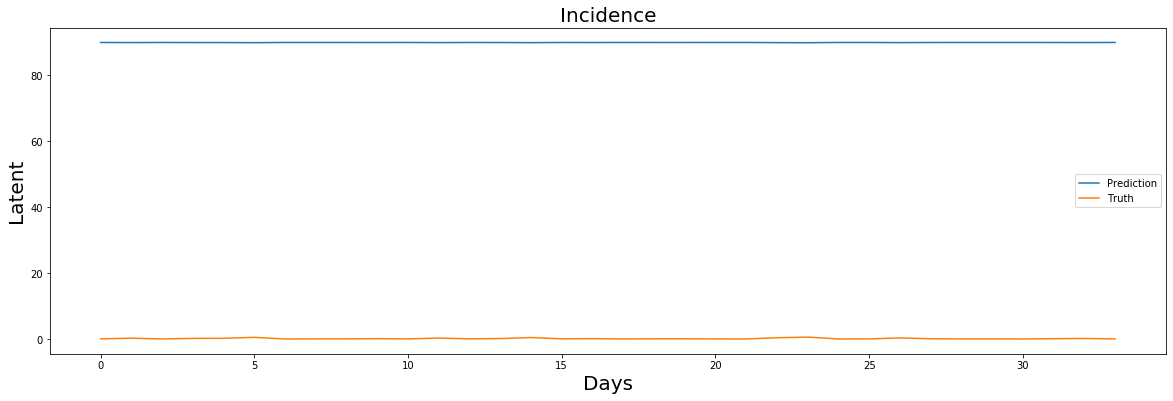

In [81]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title("Incidence", fontsize=20)
ax.set_ylabel("Latent", fontsize=20)
ax.set_xlabel("Days", fontsize=20)
ax.plot(
    predictions.mean(axis=(1, 2))[:, 0, 0], label="Prediction",
)
ax.plot(truth.mean(axis=(1, 2))[:, 0, 0], label="Truth")
ax.legend()

## Since ^ was miserable, let's model at the country level instead of the location

In [66]:
with h5py.File("data/EpiGCN/train_test.hdf5", "r") as f:
    x_train = f['x_train'].value
    x_test = f['x_test'].value
    y_train = f['y_train'].value
    y_test = f['y_test'].value

In [67]:
import torch
use_cuda = torch.cuda.is_available()
# device = torch.device("cuda:0" if use_cuda else "cpu")
device = torch.device("cpu")
print(device)

cpu


# Define Dataset

In [68]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

train_dataset = TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
test_dataset = TensorDataset(torch.FloatTensor(x_test), torch.FloatTensor(y_test))

# Define Dataloader

In [79]:
# params = {"batch_size": 12, "shuffle": True, "num_workers": 4}

train_dataloader = DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=12)
test_dataloader = DataLoader(test_dataset, batch_size=12, shuffle=False, num_workers=12)

# Define the Model!

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class BaselineLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BaselineLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size, batch_first=True
        )
        self.linear = nn.Linear(hidden_size, input_size)

    def forward(self, lstm_input):
        """
        :lstm_input: (b, 232, 232, 10, 2)
        """
        b, n_countries, n_countries, seq_len, sym = lstm_input.size()
        lstm_input = lstm_input.permute(0, 3, 1, 2, 4)
        _, (hn, __) = self.lstm(lstm_input.contiguous().view(b, seq_len, -1))
        return self.linear(hn).view(b, n_countries, n_countries, 1, sym)

# Ignite!

In [8]:
from torch.utils.tensorboard import SummaryWriter
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss
from ignite.contrib.handlers.tensorboard_logger import *

model = BaselineLSTM(input_size=232 * 232 * 2, hidden_size=2048)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

mse = torch.nn.MSELoss()
mae = torch.nn.L1Loss()

tb_logger = TensorboardLogger(log_dir="experiments/tb_logs/runs/country_level_hi2048")

trainer = create_supervised_trainer(model, optimizer, mae, device=device)

metrics = {"mae": Loss(mae), "mse": Loss(mse)}

train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
validation_evaluator = create_supervised_evaluator(
    model, metrics=metrics, device=device
)

tb_logger.attach(
    trainer,
    log_handler=OutputHandler(
        tag="training", output_transform=lambda loss: {"loss": loss}
    ),
    event_name=Events.ITERATION_COMPLETED,
)

tb_logger.attach(
    train_evaluator,
    log_handler=OutputHandler(
        tag="training",
        metric_names=["mae", "mse"],
        global_step_transform=global_step_from_engine(trainer),
    ),
    event_name=Events.EPOCH_COMPLETED,
)

tb_logger.attach(
    validation_evaluator,
    log_handler=OutputHandler(
        tag="validation",
        metric_names=["mae", "mse"],
        global_step_transform=global_step_from_engine(trainer),
    ),
    event_name=Events.EPOCH_COMPLETED,
)

# Attach the logger to the trainer to log optimizer's parameters, e.g. learning rate at each iteration
tb_logger.attach(
    trainer,
    log_handler=OptimizerParamsHandler(optimizer),
    event_name=Events.ITERATION_STARTED,
)

# Attach the logger to the trainer to log model's weights norm after each iteration
tb_logger.attach(
    trainer,
    log_handler=WeightsScalarHandler(model),
    event_name=Events.ITERATION_COMPLETED,
)

# Attach the logger to the trainer to log model's weights as a histogram after each epoch
tb_logger.attach(
    trainer, log_handler=WeightsHistHandler(model), event_name=Events.EPOCH_COMPLETED
)

# Attach the logger to the trainer to log model's gradients norm after each iteration
tb_logger.attach(
    trainer,
    log_handler=GradsScalarHandler(model),
    event_name=Events.ITERATION_COMPLETED,
)

# Attach the logger to the trainer to log model's gradients as a histogram after each epoch
tb_logger.attach(
    trainer, log_handler=GradsHistHandler(model), event_name=Events.EPOCH_COMPLETED
)


@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(trainer):
    logger.info(
        "Epoch[{}] Loss: {:.7f}".format(trainer.state.epoch, trainer.state.output)
    )


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_dataloader)
    metrics = train_evaluator.state.metrics
    logger.info(
        "Training Results - Epoch: {} MSE: {:.7f} MAE: {:.7f}".format(
            trainer.state.epoch, metrics["mse"], metrics["mae"]
        )
    )


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    validation_evaluator.run(test_dataloader)
    metrics = validation_evaluator.state.metrics
    logger.info(
        "Validation Results - Epoch: {} MSE: {:.7f} MAE: {:.7f}".format(
            trainer.state.epoch, metrics["mse"], metrics["mae"]
        )
    )
    lr_scheduler.step(metrics["mae"])


trainer.run(train_dataloader, max_epochs=100)
# We need to close the logger with we are done
tb_logger.close()

INFO:ignite.engine.engine.Engine:Engine run starting with max_epochs=100.
INFO:root:Epoch[1] Loss: 0.8331959
INFO:root:Epoch[1] Loss: 0.8331174
INFO:root:Epoch[1] Loss: 0.6629096
INFO:root:Epoch[1] Loss: 0.5930863
INFO:root:Epoch[1] Loss: 0.5682445
INFO:root:Epoch[1] Loss: 0.4229914
INFO:root:Epoch[1] Loss: 0.4068899
INFO:root:Epoch[1] Loss: 0.3774002
INFO:root:Epoch[1] Loss: 0.3228433
INFO:root:Epoch[1] Loss: 0.2961864
INFO:root:Epoch[1] Loss: 0.2601439
INFO:root:Epoch[1] Loss: 0.2199824
INFO:root:Epoch[1] Loss: 0.2257424
INFO:root:Epoch[1] Loss: 0.2067698
INFO:root:Epoch[1] Loss: 0.2005715
INFO:root:Epoch[1] Loss: 0.1781022
INFO:root:Epoch[1] Loss: 0.1840160
INFO:root:Epoch[1] Loss: 0.1651428
INFO:root:Epoch[1] Loss: 0.1498718
INFO:root:Epoch[1] Loss: 0.1519610
INFO:root:Epoch[1] Loss: 0.1508583
INFO:root:Epoch[1] Loss: 0.1378308
INFO:root:Epoch[1] Loss: 0.1288641
INFO:root:Epoch[1] Loss: 0.1418383
INFO:root:Epoch[1] Loss: 0.1283313
INFO:root:Epoch[1] Loss: 0.1307145
INFO:ignite.engi

KeyboardInterrupt: 

In [70]:
import joblib
scaler = joblib.load('data/EpiGCN/standard_scaler.pkl')

In [71]:
def get_scaled_output(y):
    y = y.view(-1, 2).numpy()
    mean = scaler.mean_
    scale = scaler.scale_
    return (scale * y + mean).reshape(-1, 232, 232, 1, 2)

In [72]:
predictions, truth = [], []
with torch.no_grad():
    for batch_x, batch_y in test_dataloader:
        logits = model(batch_x.to(device))
        predictions.append(get_scaled_output(logits.cpu()))
        truth.append(get_scaled_output(batch_y.cpu()))
predictions = np.concatenate(predictions)
truth = np.concatenate(truth)

In [73]:
truth.shape

(34, 232, 232, 1, 2)

# Test Viz

In [132]:
from ipywidgets import interact

@interact
def plot(country_id=list(range(232))):
    fig, ax = plt.subplots(2, 1, figsize=(20, 12))
    ax[0].set_title("Truth: Incidence", fontsize=20)
    ax[1].set_title("Predictions: Incidence", fontsize=20)
    ax[0].set_ylabel("Infectious_SympT", fontsize=20)
    # ax[0].set_xlabel("Days", fontsize=20)
    for i in range(truth.shape[1]):
        ax[0].plot(np.expm1(truth[:, country_id, i, 0, 0]))
        ax[1].plot(np.expm1(predictions[:, country_id, i, 0, 0]))

interactive(children=(Dropdown(description='country_id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

## Train viz

In [125]:
x_train = scaler.inverse_transform(x_train)
y_train = scaler.inverse_transform(y_train)

In [135]:
from ipywidgets import interact

@interact
def plot(country_id=list(range(232))):
    fig, ax = plt.subplots(2, 1, figsize=(20, 12))
    ax[0].set_title("X: Incidence", fontsize=20)
    ax[1].set_title("Y: Incidence", fontsize=20)
    ax[0].set_ylabel("Infectious_SympT", fontsize=20)
#     ax[0].set_xlabel("Days", fontsize=20)
    for i in range(truth.shape[1]):
        ax[0].plot(np.expm1(x_train[:, country_id, i, 0, 0]))
        ax[1].plot(np.expm1(y_train[:, country_id, i, 0, 0]))

interactive(children=(Dropdown(description='country_id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…